# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here;
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Imputer
%matplotlib inline

In [2]:
os.getcwd()

'C:\\Users\\luoyi\\Documents\\Python Scripts\\Udacity Project'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.tail()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


In [5]:
azdias.shape

(891221, 85)

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [8]:
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [10]:
feat=feat_info.copy()

In [11]:
feat.missing_or_unknown=feat.missing_or_unknown.str.strip('[]').str.split(',')

In [12]:
feat.iloc[1][3]

['-1', '0', '9']

In [13]:

var = list(azdias.columns.values)
print(var)


['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05

In [14]:
feature_obj = ['OST_WEST_KZ','CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015']


In [15]:
feature_con =[]
for feature in var:
    if feature not in feature_obj:
        feature_con.append(feature)

In [16]:
print(feature_con)

['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', '

In [17]:
feat.set_index('attribute',inplace=True)

In [18]:
feat.loc['ANZ_TITEL']

information_level     household
type                    numeric
missing_or_unknown           []
Name: ANZ_TITEL, dtype: object

In [ ]:
# Time consuming cell
#for feature in feature_obj:
    azdias[feature] = azdias[feature].map(lambda x: np.nan if str(x) in feat.loc[feature]['missing_or_unknown'] else x)

In [ ]:
# Time consuming cell
#for feature in feature_con:
    azdias[feature] = azdias[feature].map(lambda x: np.nan if str('%g'%(x)) in feat.loc[feature]['missing_or_unknown'] else x)

In [ ]:
# azdias.to_csv('azdias_nan.csv',index=False)

In [19]:
azdias = pd.read_csv('azdias_nan.csv')

In [20]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,205378.000000,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,1.743410,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,0.674312,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [21]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [22]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

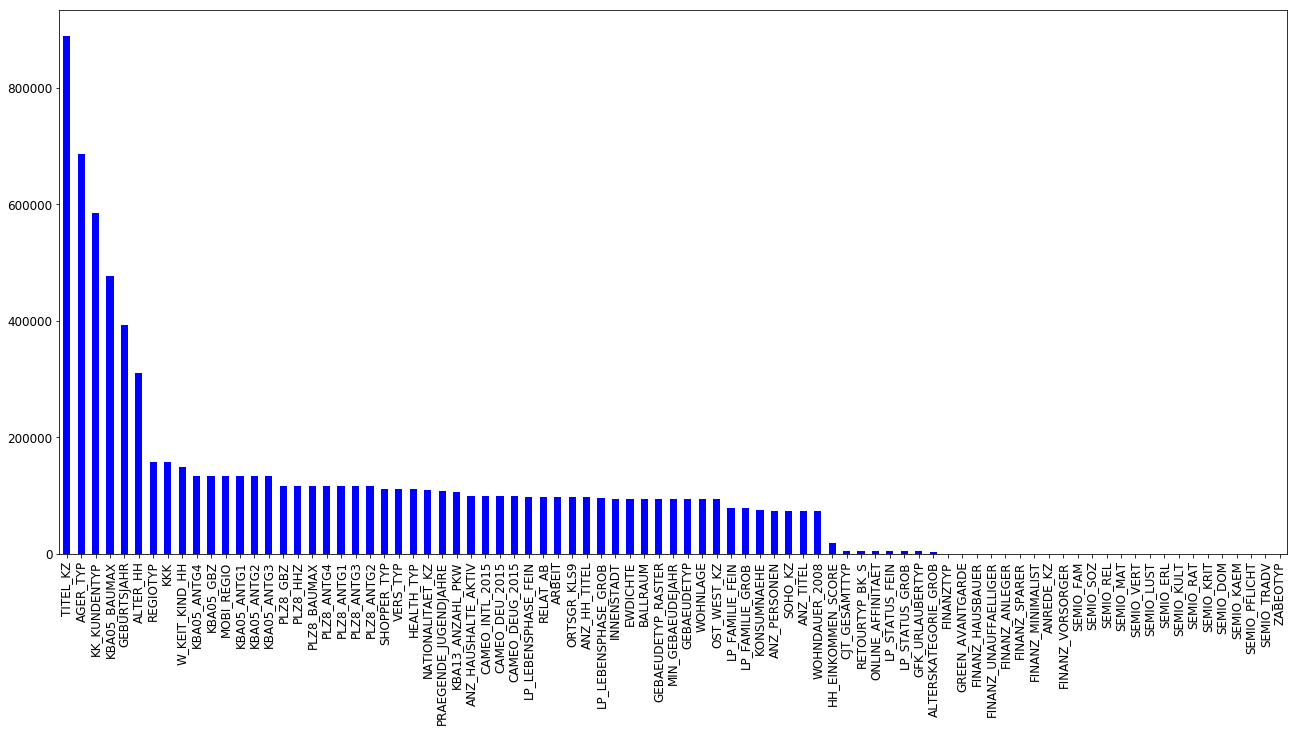

In [23]:
azdias.isnull().sum().sort_values(ascending=False).plot.bar(figsize=(22,10),fontsize=12,color='blue')

In [24]:
len(azdias)

891221

In [25]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

In [26]:
for var in outlier:
    azdias.drop(var, axis=1, inplace=True)

In [27]:
azdias.shape

(891221, 79)

#### Outlier: 
we define the outlier variables as those with more than 20% missing values

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [28]:
# How much data is missing in each row of the dataset?
azdias.isnull().sum(axis=1)

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
less_missing = azdias[azdias.isnull().sum(axis=1)<5]
more_missing = azdias[azdias.isnull().sum(axis=1)>=5]


In [30]:
print(less_missing.shape)
print(more_missing.shape)

(697109, 79)
(194112, 79)


In [31]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
ran_col = np.random.choice(less_missing.columns, 5)
ran_col

array(['FINANZ_MINIMALIST', 'SEMIO_TRADV', 'SEMIO_SOZ', 'ANZ_HH_TITEL',
       'RETOURTYP_BK_S'], dtype=object)

In [32]:
len(ran_col)

5

In [33]:
def compare_plot(col):
    fig, axs = plt.subplots(5 ,2, figsize=(12, 20))
    fig.subplots_adjust(hspace = 0.5 , wspace=0.4)
    axs = axs.ravel()

    for i in range(len(col)):
    
        sns.countplot(less_missing[col[i]], ax=axs[i*2])
        axs[i*2].set_title('less_missing')
        
        sns.countplot(more_missing[col[i]], ax=axs[i*2+1])
        axs[i*2+1].set_title('more_missing')

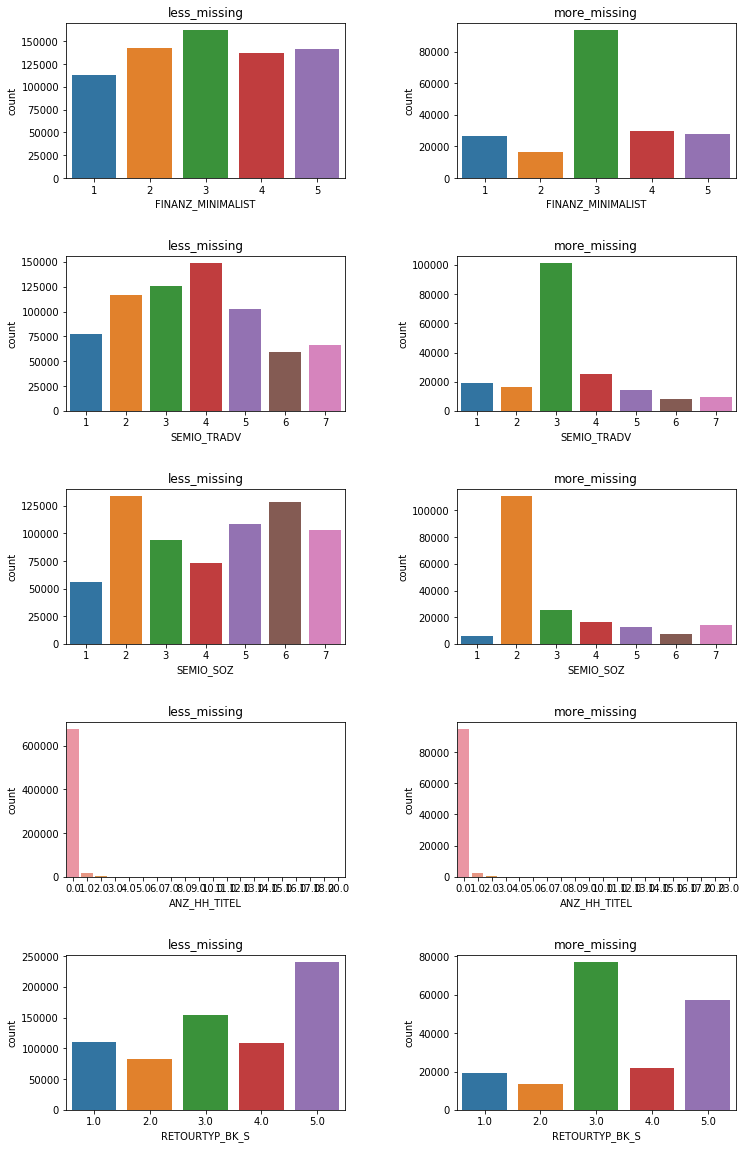

In [34]:
compare_plot(ran_col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Ans: Based on the distribution between the dataset of less missing values (less than 5) and the dataset of more missing values, we can noticed that the more_missing dataset has more medium and small values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [35]:
# How many features are there of each data type?
feat_info['type'].value_counts()


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [36]:
# Check the categorical variables
feat_info[feat_info['type']=='categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [37]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

for var in outlier:
    feat.drop(var, inplace=True)

In [38]:
feat.index

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [39]:
ctg_var = less_missing[feat[feat['type']=='categorical'].index]
ctg_var

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5,8.0,W,8.0,8A
2,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5,1.0,W,4.0,4C
4,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4,1.0,W,6.0,6B
5,2,2.0,2,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4,1.0,W,8.0,8C
6,2,5.0,4,12.0,0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,4,1.0,W,4.0,4A
7,1,3.0,5,9.0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1,8.0,W,2.0,2D
8,1,3.0,6,3.0,1,1.0,1.0,10.0,5.0,1.0,3.0,0.0,2.0,6,3.0,W,1.0,1A
9,2,4.0,1,12.0,1,1.0,1.0,3.0,2.0,1.0,3.0,0.0,2.0,4,3.0,W,1.0,1E
10,2,1.0,6,8.0,0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,3,1.0,W,9.0,9D
18,2,6.0,1,11.0,0,1.0,1.0,8.0,4.0,2.0,1.0,0.0,1.0,4,1.0,W,4.0,4C


In [40]:
ctg_var.shape

(697109, 18)

In [41]:
ctg_var.columns

Index(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
       'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'],
      dtype='object')

In [42]:
binary = []
mul_var = []
for var in ctg_var.columns:
    if len (ctg_var[var].value_counts())==2:
        binary.append(var)
    else:
        mul_var.append(var)

In [43]:
binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [44]:
mul_var

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [45]:
for col in binary:
    value_counts = less_missing[col].value_counts()
    print('\n')
    print(value_counts)
    print('Total:', value_counts.sum())



2    359280
1    337829
Name: ANREDE_KZ, dtype: int64
Total: 697109


0    539094
1    158015
Name: GREEN_AVANTGARDE, dtype: int64
Total: 697109


0.0    691232
1.0      5877
Name: SOHO_KZ, dtype: int64
Total: 697109


2.0    362039
1.0    322819
Name: VERS_TYP, dtype: int64
Total: 684858


W    546039
O    151070
Name: OST_WEST_KZ, dtype: int64
Total: 697109


In [46]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Change 'OST_WEST_KZ into numerical values
less_missing['OST_WEST_KZ'] = less_missing['OST_WEST_KZ'].map({'W': 1, 'O': 0})
# test
assert(less_missing.OST_WEST_KZ.unique().all() in [0,1])

C:\Users\luoyi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [47]:
for col in mul_var:
    value_counts = less_missing[col].value_counts()
    print('\n')
    print(value_counts)
    print('Total:', value_counts.sum())



4.0    177501
3.0    132646
2.0    126968
5.0     90227
6.0     86889
1.0     82878
Name: CJT_GESAMTTYP, dtype: int64
Total: 697109


6    269852
1    162047
5     95657
2     91435
4     49516
3     28602
Name: FINANZTYP, dtype: int64
Total: 697109


12.0    109609
10.0     91057
8.0      75544
11.0     67296
5.0      64629
4.0      55766
9.0      48796
3.0      48125
1.0      45035
7.0      36077
2.0      31954
6.0      23221
Name: GFK_URLAUBERTYP, dtype: int64
Total: 697109


1.0     365725
10.0    119455
2.0      89282
11.0     45668
8.0      19418
7.0      16163
4.0      10371
5.0      10295
9.0       9783
6.0       6905
3.0       4044
Name: LP_FAMILIE_FEIN, dtype: int64
Total: 697109


1.0    365725
5.0    174906
2.0     89282
4.0     42486
3.0     24710
Name: LP_FAMILIE_GROB, dtype: int64
Total: 697109


1.0     191414
9.0     114562
10.0    101281
2.0      90277
4.0      66812
3.0      64474
6.0      26137
5.0      21650
8.0      12137
7.0       8365
Name: LP_STATUS_FEIN, dty

In [48]:
less_missing.shape

(697109, 79)

In [49]:
drop_list = ['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEU_2015', 'GEBAEUDETYP', 'FINANZTYP', 'NATIONALITAET_KZ', 'CAMEO_DEUG_2015']

In [50]:
# Re-encode categorical variable(s) to be kept in the analysis.

for var in drop_list:
    less_missing.drop(var, axis=1, inplace=True)


C:\Users\luoyi\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [51]:
less_missing.shape

(697109, 70)

In [52]:
dummy_list= []
for var in mul_var:
    if var not in drop_list:
        dummy_list.append(var)

In [53]:
dummy_list

['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB']

In [54]:
df_dummy = pd.get_dummies(less_missing, columns=dummy_list, prefix=dummy_list)

In [55]:
df_dummy.shape

(697109, 94)

In [56]:
df_dummy

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,1,0,0,1,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1,0,0,0,0,0,1,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,1,0,1,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1,0,0,0,0,0,1,0,0,0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,1,0,0,0,0,1,0,0,0,0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,1,0,0,0,0,1,0,0,0,0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,1,0,0,0,0,0,0,0,0,1
9,3.0,2,2,4,2,3,5,4,1,2.0,...,1,0,0,0,0,0,1,0,0,0
10,3.0,2,2,2,5,3,1,5,0,2.0,...,1,0,0,0,0,1,0,0,0,0
18,2.0,2,2,4,1,5,4,1,0,2.0,...,1,0,0,0,0,0,0,0,1,0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Before we decide what to do with multiple class variables, we need to dig futher about those variables:

- **CJT_GESAMTTYP**: preferred information and buying channels for consumer (includes details of consumption minimalist and traditionalist, store and online shoppers, and cross-channel types)
- **FINANZTYP**: Most descriptive financial type for individual (includes: low financial interest, money-saver, home ownership, be prepared, investor, inconspicuous) Investigation of the data dictionary indicates that the variables contained in this feature are actually found their own variables with scales.
- **GFK_URLAUBERTYP**: Vacation habits (includes various types of vacation)

- **LP_FAMILIE_FEIN**: Family type using a fine scale (distinguishes in age, whether partnered, and children age, and generational families)
- **LP_FAMILIE_GROB**: Family type using a broader scale (captures the above categories in broader definitions)
- **LP_STATUS_FEIN**: Social status using a fine scale (distinguishes between low and high income earners as well as some elements of living/work style)
- **LP_STATUS_GROB**: Social status using a rough scale (captures the above categories in broader definitions)
- **NATIONALITAET_KZ**: Nationality based on given name analysis (includes categories of German-sounding, foreign-sounding, assimilated names)
- **SHOPPER_TYP**: Shopper typology (includes different kinds of shopper habits)
- **ZABEOTYP**: Energy consumption typology (includes categories of consumer decision making approach in considering 'green' alternatives)
- **GEBAEUDETYP**: Type of building - uncertain if this means lived in? (includes different building types)
Investigation of the data dictionary indicates that there is a binary variable that indicates youth participation in an environmental sustainability group.
- **CAMEO_DEU_2015**: Wealth / Life Stage Typology using a fine scale (includes different descriptions of class)

- **CAMEO_DEUG_2015**: Wealth / Life Stage Typology using a broader scale (captures the above categories in broader definitions)



#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Before we decide what to do with multiple class variables, we need to dig futher about those variables:

- **CJT_GESAMTTYP**: preferred information and buying channels for consumer 
- **FINANZTYP**: Most descriptive financial type for individual 
- **GFK_URLAUBERTYP**: Vacation habits 
- **LP_FAMILIE_FEIN**: Family type using a fine scale 
- **LP_FAMILIE_GROB**: Family type using a broader scale 
- **LP_STATUS_FEIN**: Social status using a fine scale 
- **LP_STATUS_GROB**: Social status using a rough scale 
- **NATIONALITAET_KZ**: Nationality based on given name analysis 
- **SHOPPER_TYP**: Shopper typology 
- **ZABEOTYP**: Energy consumption typology 
- **GEBAEUDETYP**: Type of building
- **CAMEO_DEU_2015**: Wealth / Life Stage Typology using a fine scale 
- **CAMEO_DEUG_2015**: Wealth / Life Stage Typology using a broader scale 

General speaking, we have two categories of variable here: one for consumers' shopping behavior and the other is consumers' background. I will pick the more generalised variable for example, I'd like to keep "CJT_GESAMTTYP" as consumers' shopping path definitely matters to goal which is to figure out consumer clusters for mailing promotion. Due to the privacy sensitivity, I would keep all indication variable in a broader and rough scale instead of detailed scale.

drop_list = ['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEU_2015']


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [57]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
df_dummy['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    162871
8.0     126885
5.0      77593
10.0     76403
3.0      48827
15.0     37085
11.0     31244
9.0      31001
6.0      24070
12.0     22362
4.0      19300
1.0      17253
2.0       6624
13.0      4956
7.0       3735
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [58]:
mainstream = [1, 3, 5, 8, 10, 12, 14]
df_dummy['MAINSTREAM_AVANTGARDE'] = np.where(df_dummy.PRAEGENDE_JUGENDJAHRE.isin(mainstream), 0, 1)

In [59]:
df_dummy.shape

(697109, 95)

In [60]:
df_dummy['DEKADE'] = df_dummy['PRAEGENDE_JUGENDJAHRE'].map({1.0: 1940, 2.0: 1940, 3.0: 1950, 4.0: 1950, 5.0: 1960, 
                  6.0: 1960, 7.0: 1960, 8.0: 1970, 9.0: 1970, 10.0: 1980, 
                  11.0: 1980, 12.0: 1980, 13.0: 1980, 14.0: 1990, 15.0: 1990})

In [61]:
df_dummy['DEKADE']

1         1990.0
2         1990.0
4         1970.0
5         1950.0
6         1980.0
7         1970.0
8         1980.0
9         1990.0
10        1950.0
18        1980.0
19        1970.0
21        1980.0
22        1990.0
27        1980.0
28        1980.0
29        1960.0
31        1980.0
32        1990.0
33        1970.0
34        1950.0
36        1970.0
37        1970.0
38        1980.0
40           NaN
41        1990.0
42        1990.0
43        1990.0
44        1970.0
45        1960.0
47        1950.0
           ...  
891189    1980.0
891190    1950.0
891191    1950.0
891192    1990.0
891193    1960.0
891194    1980.0
891195    1970.0
891196    1990.0
891197    1980.0
891198    1990.0
891199    1980.0
891200    1990.0
891201    1980.0
891202    1980.0
891204    1980.0
891205    1950.0
891206    1990.0
891207    1940.0
891208    1970.0
891209    1990.0
891210    1970.0
891211    1970.0
891212    1950.0
891213    1980.0
891214    1990.0
891215    1980.0
891216    1990.0
891217    1980

In [62]:
df_dummy.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [63]:
df_dummy.shape

(697109, 95)

In [64]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

df_dummy['CAMEO_INTL_2015'].value_counts()

51.0    119315
41.0     81910
24.0     79872
14.0     55376
43.0     50462
54.0     40888
25.0     35343
22.0     28333
45.0     23690
13.0     23021
55.0     20976
23.0     18782
52.0     18309
34.0     16326
15.0     15460
31.0     15042
44.0     13126
12.0     11278
35.0      9189
32.0      9124
33.0      8446
Name: CAMEO_INTL_2015, dtype: int64

-11: Wealthy Households - Pre-Family Couples & Singles

-12: Wealthy Households - Young Couples With Children

-13: Wealthy Households - Families With School Age Children

-14: Wealthy Households - Older Families &  Mature Couples

-15: Wealthy Households - Elders In Retirement

-21: Prosperous Households - Pre-Family Couples & Singles

-22: Prosperous Households - Young Couples With Children

-23: Prosperous Households - Families With School Age Children

-24: Prosperous Households - Older Families & Mature Couples

-25: Prosperous Households - Elders In Retirement

-31: Comfortable Households - Pre-Family Couples & Singles

-32: Comfortable Households - Young Couples With Children

-33: Comfortable Households - Families With School Age Children

-34: Comfortable Households - Older Families & Mature Couples

-35: Comfortable Households - Elders In Retirement

-41: Less Affluent Households - Pre-Family Couples & Singles

-42: Less Affluent Households - Young Couples With Children

-43: Less Affluent Households - Families With School Age Children

-44: Less Affluent Households - Older Families & Mature Couples

-45: Less Affluent Households - Elders In Retirement

-51: Poorer Households - Pre-Family Couples & Singles

-52: Poorer Households - Young Couples With Children

-53: Poorer Households - Families With School Age Children

-54: Poorer Households - Older Families & Mature Couples

-55: Poorer Households - Elders In Retirement

In [65]:
df_dummy['CAMEO_INTL_2015']=df_dummy['CAMEO_INTL_2015'].astype(float)

In [66]:
# Higher value means more wealth
df_dummy['WEALTH'] = (df_dummy.CAMEO_INTL_2015//10-6).abs()

In [67]:
df_dummy['FLY_TYP'] = df_dummy.CAMEO_INTL_2015%10
df_dummy.shape

(697109, 97)

In [68]:
df_dummy['FLY_TYP']

1         1.0
2         4.0
4         3.0
5         4.0
6         2.0
7         4.0
8         3.0
9         5.0
10        1.0
18        4.0
19        4.0
21        5.0
22        1.0
27        1.0
28        3.0
29        2.0
31        1.0
32        4.0
33        1.0
34        5.0
36        1.0
37        4.0
38        5.0
40        NaN
41        5.0
42        3.0
43        5.0
44        4.0
45        1.0
47        5.0
         ... 
891189    5.0
891190    5.0
891191    4.0
891192    2.0
891193    3.0
891194    4.0
891195    5.0
891196    3.0
891197    4.0
891198    4.0
891199    1.0
891200    2.0
891201    1.0
891202    1.0
891204    4.0
891205    4.0
891206    5.0
891207    1.0
891208    4.0
891209    1.0
891210    1.0
891211    1.0
891212    1.0
891213    4.0
891214    3.0
891215    1.0
891216    1.0
891217    1.0
891219    1.0
891220    3.0
Name: FLY_TYP, Length: 697109, dtype: float64

In [69]:
df_dummy.drop('CAMEO_INTL_2015', axis=1, inplace=True)
df_dummy.shape

(697109, 96)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' have been decoded into 4 different columns and the original variable columns have been deleted. For other mixed type features, I have keeping them inside the analysis.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [72]:

def clean_data(azdias):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    feature_obj = ['OST_WEST_KZ','CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015']
    feature_con =[]
    for feature in list(azdias.columns.values):
        if feature not in feature_obj:
            feature_con.append(feature)
            
    feat=feat_info.copy()
    feat.set_index('attribute',inplace=True)
    
    # convert missing value codes into NaNs, ...
    for feature in feature_obj:
        azdias[feature] = azdias[feature].map(lambda x: np.nan if str(x) in feat.loc[feature]['missing_or_unknown'] else x)
    
    for feature in feature_con:
        azdias[feature] = azdias[feature].map(lambda x: np.nan if str('%g'%(x)) in feat.loc[feature]['missing_or_unknown'] else x)
    
    # remove selected columns 
    outlier = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    
    for var in outlier:
        azdias.drop(var, axis=1, inplace=True)
        
    # remove selected rows
    for var in outlier:
        feat.drop(var, inplace=True)
    
    less_missing = azdias[azdias.isnull().sum(axis=1)<5]    
            
    drop_list = ['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEU_2015', 'GEBAEUDETYP', 'FINANZTYP', 'NATIONALITAET_KZ', 'CAMEO_DEUG_2015']
      
    for var in drop_list:
        less_missing.drop(var, axis=1, inplace=True)
        
  
    recode = {'O': 0, 'W': 1}
    less_missing.replace({'OST_WEST_KZ': recode}, inplace=True)       
    
    # feature engineering of categorical features  
        
    dummy_list= ['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB']
                         
    df_dummy = pd.get_dummies(less_missing, columns=dummy_list, prefix=dummy_list)
    # feature engineering of mixed features
        
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    df_dummy['MAINSTREAM_AVANTGARDE'] = np.where(df_dummy.PRAEGENDE_JUGENDJAHRE.isin(mainstream), 0, 1)
    df_dummy['DEKADE'] = df_dummy['PRAEGENDE_JUGENDJAHRE'].map({1.0: 1940, 2.0: 1940, 3.0: 1950, 4.0: 1950, 5.0: 1960, 
                  6.0: 1960, 7.0: 1960, 8.0: 1970, 9.0: 1970, 10.0: 1980, 
                  11.0: 1980, 12.0: 1980, 13.0: 1980, 14.0: 1990, 15.0: 1990})
    df_dummy.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
        
    df_dummy['CAMEO_INTL_2015']=df_dummy['CAMEO_INTL_2015'].astype(float)
    df_dummy['WEALTH'] = (df_dummy.CAMEO_INTL_2015//10-6).abs()
    df_dummy['FLY_TYP'] = df_dummy.CAMEO_INTL_2015%10
    df_dummy.drop('CAMEO_INTL_2015', axis=1, inplace=True)
        
    df1 = df_dummy
    # Return the cleaned dataframe.
    return df1

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [73]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
df_dummy.isnull().sum()


ALTERSKATEGORIE_GROB      1417
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP               12251
LP_LEBENSPHASE_FEIN          2
LP_LEBENSPHASE_GROB          1
RETOURTYP_BK_S               0
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
SOHO_KZ                      0
VERS_TYP                 12251
ANZ_PERSONEN                 0
                         ...  
CJT_GESAMTTYP_3.0            0
CJT_GESA

In [78]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaler.fit(df_dummy.dropna()) # Drop all nas for fit purpose
imp = Imputer()
df_imp = imp.fit_transform(df_dummy) # Replace the na with mean
df = scaler.fit_transform(df_imp)

C:\Users\luoyi\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\luoyi\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

The majority of the missing values had been removed when we creat the less_missing dataframe, but we still have more than 140000 missing values, so we try to use the mean value of the column to replace those missing values

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [79]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(df)

In [80]:
# Investigate the variance accounted for by each principal component.

pca.explained_variance_ratio_

array([1.38058817e-01, 9.79849913e-02, 6.45554723e-02, 4.90097539e-02,
       3.69524231e-02, 2.50186339e-02, 2.20229415e-02, 1.99996160e-02,
       1.79212464e-02, 1.65386199e-02, 1.61582401e-02, 1.48710489e-02,
       1.45506251e-02, 1.42421232e-02, 1.35212914e-02, 1.32826329e-02,
       1.31080233e-02, 1.28316175e-02, 1.24531510e-02, 1.23060191e-02,
       1.19614949e-02, 1.17629779e-02, 1.15907052e-02, 1.15297400e-02,
       1.14297632e-02, 1.12767204e-02, 1.11211154e-02, 1.08784150e-02,
       1.08119178e-02, 1.07614484e-02, 1.05442215e-02, 1.04175354e-02,
       1.03515662e-02, 1.02652867e-02, 9.93498997e-03, 9.27228761e-03,
       9.12370751e-03, 8.94949413e-03, 8.58031440e-03, 8.29327077e-03,
       8.03326342e-03, 7.67306827e-03, 7.55680249e-03, 7.28796351e-03,
       7.03936621e-03, 6.93837516e-03, 6.49029194e-03, 6.17144091e-03,
       5.28884593e-03, 5.26731505e-03, 5.14742696e-03, 4.71506671e-03,
       4.48543287e-03, 4.35081385e-03, 4.26060925e-03, 4.23151601e-03,
      

In [81]:

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    
    
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 9))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component",fontsize=16)
    ax.set_ylabel("Variance Explained (%)",fontsize=16)
    plt.title('Explained Variance Per Principal Component' ,fontsize=20)


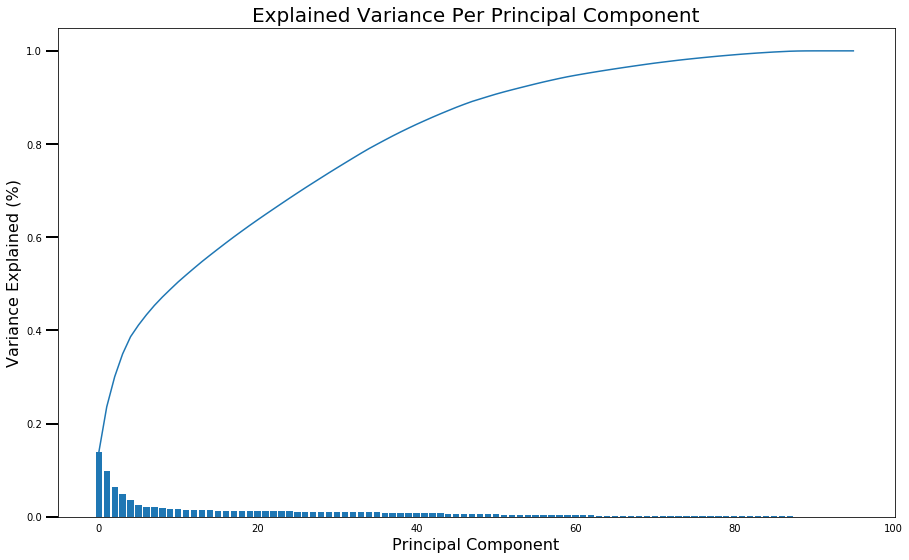

In [82]:
scree_plot(pca)

In [83]:
for i in np.arange(5, 50, 5):
    print('For {} components, explained variance:'.format(i), 
          pca.explained_variance_ratio_[:i].sum())

For 5 components, explained variance: 0.38656145787437324
For 10 components, explained variance: 0.48806251550824736
For 15 components, explained variance: 0.5614058440654145
For 20 components, explained variance: 0.6253872878454272
For 25 components, explained variance: 0.6836619689558656
For 30 components, explained variance: 0.7385115859139072
For 35 components, explained variance: 0.790025185717178
For 40 components, explained variance: 0.8342442601251614
For 45 components, explained variance: 0.8718347240184282


In [84]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_30 = PCA(n_components=30)
X_pca_30 = pca_30.fit_transform(df)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

The top four components explained around 30% of the variance, and it takes 20 components to achieve around 50% capture rate. At 30 components, the model is able to explain 60% of the variance. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [85]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_output(data,pca):
    # Create dimensions index
    dimensions = ['Dimension {}'.format(i) for i \
                  in range(1, len(pca.components_) + 1)]
    
    # Capture pca components
    pca_comp = pca.components_
    
    # Create components df
    components_df = pd.DataFrame(np.round(pca_comp, 4), 
                              columns= data.columns)
    components_df.index = dimensions
    
    # Create PCA variance explained df
    ratios = pca.explained_variance_ratio_.reshape(len(pca_comp), 1)
    ratios_df = pd.DataFrame(np.round(ratios, 4), 
                             columns=['Explained Variance'])
    ratios_df.index = dimensions
    
    # Return combined df
    return pd.merge(ratios_df, components_df, left_index=True, right_index=True)


In [86]:
results = pca_output(df_dummy, pca_30)
results.head()

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,MAINSTREAM_AVANTGARDE,DEKADE,WEALTH,FLY_TYP
Dimension 1,0.1381,-0.0914,0.0074,-0.1970,0.1147,-0.0868,0.0443,0.0530,0.1546,-0.1073,...,-0.0861,0.2052,-0.0156,-0.0331,-0.1175,-0.1185,-0.1035,0.0764,-0.1883,-0.1113
Dimension 2,0.0980,0.2590,0.0721,0.0894,-0.2443,0.2344,-0.2122,-0.2248,0.0964,-0.0015,...,-0.0498,0.0152,-0.0139,-0.0031,-0.0156,0.0141,0.0084,-0.2540,-0.0477,0.0143
Dimension 3,0.0646,0.0626,-0.3685,0.1535,-0.0860,0.0817,-0.1766,-0.0756,-0.0558,0.0613,...,0.0005,-0.0226,-0.0285,0.0253,0.0038,0.0452,0.0622,-0.0904,-0.0179,-0.0074
Dimension 4,0.0490,-0.0128,0.0460,0.0276,-0.0004,-0.0046,-0.0657,0.0284,-0.0497,0.2434,...,0.2462,-0.0121,-0.0708,0.0631,-0.1243,0.1972,0.2375,0.0277,0.0251,0.0129
Dimension 5,0.0370,0.0608,-0.0260,-0.0090,-0.0183,0.0286,0.0813,-0.1126,0.0491,-0.2783,...,0.2526,0.0790,-0.0602,0.0036,0.1456,-0.2010,-0.2748,-0.0313,-0.1310,-0.0705


In [87]:
def plot_pca_dim(results_df, pca, dimension_name, figsize=(16, 10)):
    # Collect dimension info
    dimension = results_df.loc[dimension_name, 'ALTERSKATEGORIE_GROB':]\
    .sort_values(ascending=False)
    positive = dimension[dimension >=0]
    negative = dimension[dimension <0]
    
    # Create bar plot
    plt.figure(figsize=figsize)
    plt.subplot(211)
    positive.plot(kind='bar')
    plt.axhline(y=0.15, ls='--', c='#b3b3b3', lw=1)
    #plt.grid(axis='y')
    plt.ylabel("Feature Weights")
    plt.subplot(212)
    negative.plot(kind='bar')
    plt.axhline(y=-0.15, ls='--', c='#b3b3b3', lw=1);
    #plt.grid(axis='y')
    plt.ylabel("Feature Weights")
    plt.subplots_adjust(bottom=0.8)
    plt.suptitle("{}: {}% Variance Explained".format(
        dimension_name, 
        np.round(results_df.loc[dimension_name, 'Explained Variance']*100, 2)),
                 fontsize=18)
    plt.tight_layout()

In [88]:
# Implement print-out of higher weighted features
def weighted_features(results, dimension_name):
    print("High Positive\n", 
      results.loc[dimension_name][results.loc[dimension_name] >= 0.15].sort_values(ascending=False))
    print("\nHigh Negative\n", 
      results.loc[dimension_name][results.loc[dimension_name] <= -0.15].sort_values())

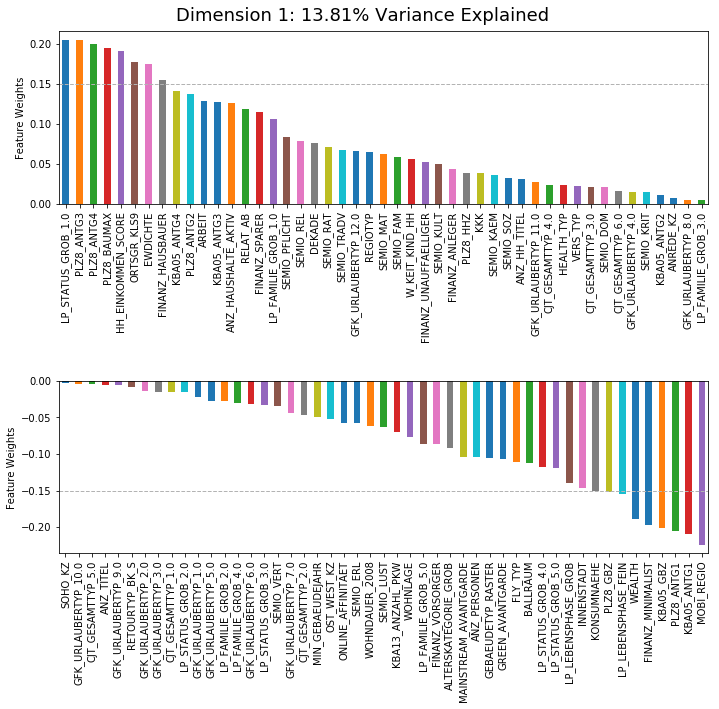

In [89]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_dim(results, pca_30, 'Dimension 1', figsize=(10, 10))


In [90]:
weighted_features(results, 'Dimension 1')

High Positive
 LP_STATUS_GROB_1.0    0.2052
PLZ8_ANTG3            0.2049
PLZ8_ANTG4            0.1994
PLZ8_BAUMAX           0.1948
HH_EINKOMMEN_SCORE    0.1910
ORTSGR_KLS9           0.1776
EWDICHTE              0.1752
FINANZ_HAUSBAUER      0.1546
Name: Dimension 1, dtype: float64

High Negative
 MOBI_REGIO            -0.2246
KBA05_ANTG1           -0.2091
PLZ8_ANTG1            -0.2050
KBA05_GBZ             -0.2010
FINANZ_MINIMALIST     -0.1970
WEALTH                -0.1883
LP_LEBENSPHASE_FEIN   -0.1546
PLZ8_GBZ              -0.1519
KONSUMNAEHE           -0.1512
Name: Dimension 1, dtype: float64


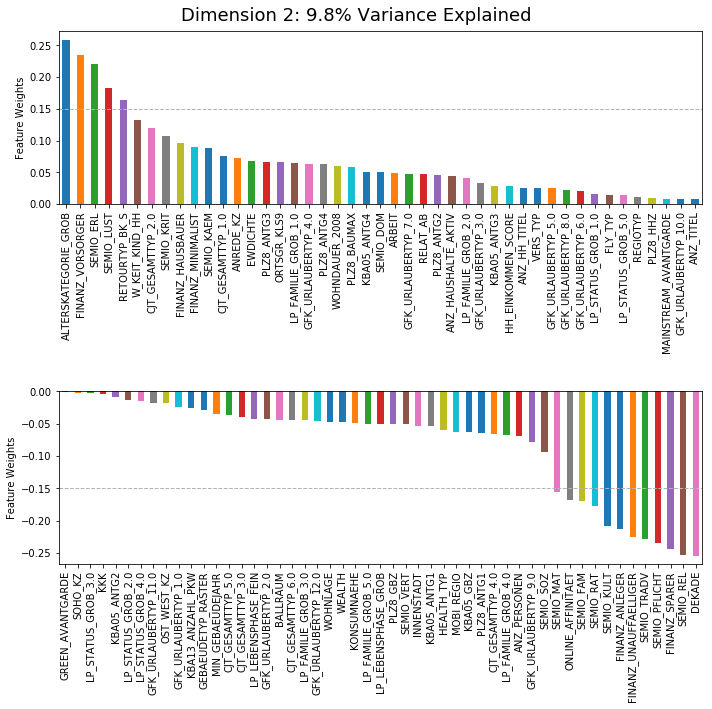

In [91]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_dim(results, pca_30, 'Dimension 2', figsize=(10, 10))


In [92]:
weighted_features(results, 'Dimension 2')

High Positive
 ALTERSKATEGORIE_GROB    0.2590
FINANZ_VORSORGER        0.2344
SEMIO_ERL               0.2200
SEMIO_LUST              0.1831
RETOURTYP_BK_S          0.1646
Name: Dimension 2, dtype: float64

High Negative
 DEKADE                  -0.2540
SEMIO_REL               -0.2533
FINANZ_SPARER           -0.2443
SEMIO_PFLICHT           -0.2338
SEMIO_TRADV             -0.2289
FINANZ_UNAUFFAELLIGER   -0.2248
FINANZ_ANLEGER          -0.2122
SEMIO_KULT              -0.2080
SEMIO_RAT               -0.1774
SEMIO_FAM               -0.1698
ONLINE_AFFINITAET       -0.1675
SEMIO_MAT               -0.1552
Name: Dimension 2, dtype: float64


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Dimension 1

### High positive:
- LP_STATUS_GROB_1.0 (low-income earners)
- PLZ8_ANTG3 (Number of 6-10 family houses in PLZ8 region)
- PLZ8_ANTG4 (Number of 10+ familiy houses in PLZ8 region)
- PLZ8_BAUMAX (Most common building type within the PLZ8 region)
- HH_EINKOMMEN_SCORE (Estimated household net income)
- ORTSGR_KLS9 (Size of community)
- EWDICHTE (Density of households per square kilometer)
### High negative:
- MOBI_REGIO (Movement patterns)
- KBA05_ANTG1 (Number of 1-2 family houses in the microcell)
- PLZ8_ANTG1 (Number of 1-2 family houses in the PLz8 region)
- FINANZ_SPARER (Financial typology: Money saver)
- KBA05_GBZ (Number of buildings in the microcell)
- WEALTH (High -ve: more likely poor)

This component likely represent young people, who has financial problems and low incomes, living in high density apartments. They are not likely to be interested in saving. They are more of impulse buying type and not the promotion motivated type.


## Dimension 2

### High positive:
- ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)
- FINANZ_VORSORGER  (Financial typology: be prepared)
- SEMIO_ERL (event-oriented)
- SEMIO_LUST (sensual-minded)
- RETOURTYP_BK_S (Return type)

### High negative:
- DEKADE (Year born, small value-older)
- SEMIO_REL (Relgious, 1: highest affinity)         
- FINANZ_UNAUFFAELLIGER (inconspicuous, small value means high level of invenst)   
- SEMIO_PFLICHT (dutiful)          
- SEMIO_TRADV (tradional-minded) 
- FINANZ_SPARER (money-saver)                                  
- SEMIO_FAM  (family-minded)                   
- SEMIO_MAT  (materialistic)  
- FINANZ_ANLEGER (investor, small value means high level of invenst)        
- SEMIO_KULT (cultural-minded)             
- SEMIO_RAT (rational)             
- ONLINE_AFFINITAET (Online affinity, small value means less affinity) 


This component seems to describe older people, who are consider themselves traditional minded with rational thinking, very dutiful, with heavy investment but acting inconspicuous, and not favor about internet.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [93]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
k_means = range(1, 31)
scores = []

for k in k_means:
    print('Starting k = {} fitting'.format(k))
    model = KMeans(k).fit(X_pca_30)
    score = model.score(X_pca_30)
    scores.append(-score)   

Starting k = 1 fitting
Starting k = 2 fitting
Starting k = 3 fitting
Starting k = 4 fitting
Starting k = 5 fitting
Starting k = 6 fitting
Starting k = 7 fitting
Starting k = 8 fitting
Starting k = 9 fitting
Starting k = 10 fitting
Starting k = 11 fitting
Starting k = 12 fitting
Starting k = 13 fitting
Starting k = 14 fitting
Starting k = 15 fitting
Starting k = 16 fitting
Starting k = 17 fitting
Starting k = 18 fitting
Starting k = 19 fitting
Starting k = 20 fitting
Starting k = 21 fitting
Starting k = 22 fitting
Starting k = 23 fitting
Starting k = 24 fitting
Starting k = 25 fitting
Starting k = 26 fitting
Starting k = 27 fitting
Starting k = 28 fitting
Starting k = 29 fitting
Starting k = 30 fitting


Text(0, 0.5, 'SSE')

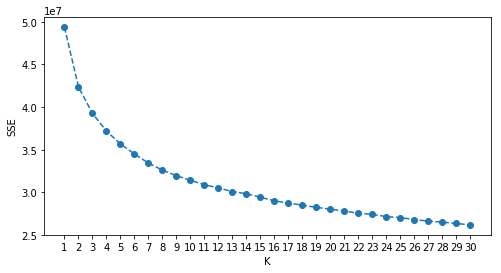

In [94]:
# Plot elbow plot
x = range(1, 31)
plt.figure(figsize=(8, 4))
plt.plot(x, scores, linestyle='--', marker='o')
plt.xticks(x)
plt.xlabel('K')
plt.ylabel('SSE')

In [95]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_8 = KMeans(n_clusters=8).fit(X_pca_30)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

The clustering curve didn't show us a very obvious ratio change, but we do see the ratio becames flat at 8 and 9, so I decide to use 8 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [70]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.shape

(191652, 85)

In [74]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cl = customers.copy()
customers_cl = clean_data(customers_cl)


C:\Users\luoyi\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\luoyi\Anaconda3\lib\site-packages\pandas\core\generic.py:5821: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [75]:
customers_cl.isnull().sum()

ALTERSKATEGORIE_GROB       8
ANREDE_KZ                149
FINANZ_MINIMALIST          1
FINANZ_SPARER             14
FINANZ_VORSORGER           3
FINANZ_ANLEGER            16
FINANZ_UNAUFFAELLIGER     34
FINANZ_HAUSBAUER          16
GREEN_AVANTGARDE           0
HEALTH_TYP                 4
LP_LEBENSPHASE_FEIN        0
LP_LEBENSPHASE_GROB        0
RETOURTYP_BK_S             0
SEMIO_SOZ                  3
SEMIO_FAM                 10
SEMIO_REL                 11
SEMIO_MAT                  7
SEMIO_VERT                 2
SEMIO_LUST                 7
SEMIO_ERL                  0
SEMIO_KULT                38
SEMIO_RAT                  1
SEMIO_KRIT                 5
SEMIO_DOM                  1
SEMIO_KAEM                 1
SEMIO_PFLICHT              0
SEMIO_TRADV                0
SOHO_KZ                    2
VERS_TYP                  78
ANZ_PERSONEN               0
                        ... 
CJT_GESAMTTYP_3.0          0
CJT_GESAMTTYP_4.0          0
CJT_GESAMTTYP_5.0          0
CJT_GESAMTTYP_

In [76]:
customers_cl.shape

(334, 96)

In [96]:
customers_imp = imp.transform(customers_cl)

In [97]:
customers_std = scaler.transform(customers_imp)

In [98]:
customers_pca = pca_30.transform(customers_std)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [99]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
population_predict = pd.DataFrame(np.array(kmeans_8.predict(X_pca_30)), columns=['Predictions'])
customer_predict = pd.DataFrame(np.array(kmeans_8.predict(customers_pca)), columns=['Predictions'])

In [100]:
pop_count = population_predict.groupby('Predictions').size()
cus_count = customer_predict.groupby('Predictions').size()
print(pop_count)
print(cus_count)

Predictions
0     62598
1    119826
2     99038
3     97305
4    106442
5     77266
6     62704
7     71930
dtype: int64
Predictions
0     10
1     25
2    102
3     49
4     95
5     24
6      9
7     20
dtype: int64


In [102]:
pop_miss = pd.Series(azdias.shape[0]-df_dummy.shape[0])
cus_miss = pd.Series(customers.shape[0]-customers_cl.shape[0])
pop_count = pop_count.append(pop_miss)
cus_count = cus_count.append(cus_miss)
print(pop_count)
print(cus_count)


0     62598
1    119826
2     99038
3     97305
4    106442
5     77266
6     62704
7     71930
0    194112
dtype: int64
0        10
1        25
2       102
3        49
4        95
5        24
6         9
7        20
0    191318
dtype: int64


In [103]:
pop_count.index = range(9)
cus_count.index = range(9)

In [104]:
pop_prop = (pop_count/pop_count.sum()).reset_index()
cus_prop = (cus_count/cus_count.sum()).reset_index()

In [105]:
pop_prop['source'] = 'population'
pop_prop.columns = ['label', 'proportion', 'source']
cus_prop['source'] = 'customers'
cus_prop.columns = ['label', 'proportion', 'source']

In [106]:
predictions = pd.concat([pop_prop, cus_prop])
predictions.head()

,label,proportion,source
0,0,0.070238,population
1,1,0.134451,population
2,2,0.111126,population
3,3,0.109182,population
4,4,0.119434,population


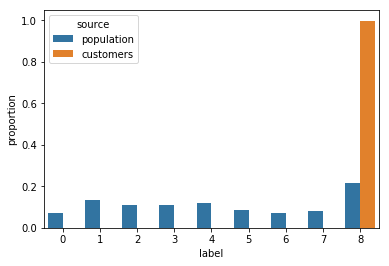

In [107]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
sns.barplot(x='label', y='proportion', hue = 'source', data=predictions)

label 8 is overrepresented in the customer data compared to the population data

In [108]:
customer_labels = pd.merge(left=pd.DataFrame(customers_pca), right=customer_predict, left_index=True, right_index=True)
customer_labels.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Predictions
0,1.522287,-0.763596,-2.647670,-1.235609,-2.199187,0.611298,-0.396568,-0.966099,-0.358828,1.378756,...,-0.070989,-0.361732,-0.597054,1.158362,0.768884,-0.510889,-1.663491,-0.825899,-1.287478,5
1,1.401397,0.851752,-2.163866,2.833683,4.816807,-0.453341,2.966902,0.322864,-1.353487,0.050290,...,0.390363,0.874627,-0.785872,1.655014,-0.333235,0.006718,-0.426133,-0.749158,-0.213039,4
2,2.498835,-1.006452,-2.525509,-1.062338,-2.211265,2.681358,-0.476831,0.685820,-0.330278,2.023391,...,1.384902,-0.545190,0.606548,0.156391,1.159932,0.083888,0.610243,-0.427515,-0.585183,7
3,-0.441846,1.321733,1.807480,-0.552687,-0.987850,-1.411930,-1.337923,0.335404,-0.127337,2.747326,...,0.506933,0.253473,-1.711846,-0.981907,0.868693,-1.045934,-1.011905,-0.227555,0.838017,2
4,3.177332,2.621050,-1.813946,2.139168,0.331463,0.000160,-0.714213,0.262042,-1.379385,0.880335,...,-1.019468,-0.683855,1.023623,1.477893,1.059111,2.489746,-1.167216,-1.032180,0.512828,4


In [111]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
under_transform = pca_30.inverse_transform(customer_labels.query('Predictions == 0').drop('Predictions', axis=1))
under_regular = scaler.inverse_transform(under_transform)
under_df = pd.DataFrame(under_regular, columns=customers_cl.columns)


In [113]:
under_df.mean()

ALTERSKATEGORIE_GROB        2.442677
ANREDE_KZ                   1.103593
FINANZ_MINIMALIST           2.162322
FINANZ_SPARER               3.966409
FINANZ_VORSORGER            2.515524
FINANZ_ANLEGER              3.145527
FINANZ_UNAUFFAELLIGER       3.683994
FINANZ_HAUSBAUER            3.288650
GREEN_AVANTGARDE            0.201015
HEALTH_TYP                  2.490564
LP_LEBENSPHASE_FEIN         6.790102
LP_LEBENSPHASE_GROB         2.271057
RETOURTYP_BK_S              2.967978
SEMIO_SOZ                   5.724553
SEMIO_FAM                   5.620941
SEMIO_REL                   4.854165
SEMIO_MAT                   4.073274
SEMIO_VERT                  5.485370
SEMIO_LUST                  3.865903
SEMIO_ERL                   3.300324
SEMIO_KULT                  5.586816
SEMIO_RAT                   3.393192
SEMIO_KRIT                  3.598768
SEMIO_DOM                   3.420491
SEMIO_KAEM                  3.000686
SEMIO_PFLICHT               4.595527
SEMIO_TRADV                 3.775133
S

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)
This segment is unpopular to the mailing company. As this segment represents young generation who in their 30s, lives in apartment, low wealth, and little interest of money saving program. Therefore, mailing promotion seems no appealing to young generations.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.